## Importing libraries/modules

In [1]:
import utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import Counter
import re

In [2]:
DATA_DIR = 'Data'
CACHE_DIR = 'Cache'
SPEAKER_INFO_FILE_PATH = os.path.join(DATA_DIR, 'speaker_attributes.parquet')
CACHE_FILE_PATH = os.path.join(CACHE_DIR, 'processed_data.json.bz2')

## Useful functions

In [3]:
@utils.cache_to_file_pickle("function-groupby_speaker", cache_dir = CACHE_DIR)
def groupby_speaker(input_file_path):
    """
    """
    speakers_dict = {}
    
    def processing_func(line):
        # Inner function can modify dictionary even without nonlocal keywork because dictionaries
        # are mutable objects. Nevertheless, for clarity:
        nonlocal speakers_dict
    
        # If no qids are available for the current quote, we drop it.
        if not line['qids']:
            return
            
        qids = tuple(line['qids']) if len(line['qids']) > 1 else line['qids'][0]

        if qids in speakers_dict:
            speakers_dict[qids]['quote_count'] += 1
            # speakers_dict[qids]['speaker']     |= set([line['speaker']])
            speakers_dict[qids]['date'].append(line['first_date'])
            speakers_dict[qids]['num_occurrences'].append(line['num_occurrences'])

        else:
            speakers_dict[qids] = {'quote_count': 1, \
                                   # 'speaker': set([line['speaker']]), \
                                   'date': [line['first_date']], \
                                   'num_occurrences': [line['num_occurrences']]}
    
    utils.process_json_file_per_line(input_file_path, processing_func)
    
    return speakers_dict

## Choices to make

- Cas quand plusieurs qids par quote, lequel on prend ? (je sais pas s'il y a moyen de savoir laquelle est la plus populaire, peut-être celle qui a le plus de liens externes) 88% des fois c'est OK -> on les drop ?

- Il faut link les QIDs avec les strings correspondant aux informations

- Problème avec les dates of birth: quand mois/jour pas connu set à 0 -> datetime pas content, on garde que l'année peut-être suffisant ?
- Pour le gender quand pas connu je jette les données ?
- Idem pour les autres colonnes ? 

## Questions to answer

- How the age, occupation, genre,... influences in the virality of the speaker ?

## Load datasets

- Data from quote dataset

In [4]:
# Load data from quotes
data_quotes = groupby_speaker(input_file_path = CACHE_FILE_PATH)

# Convert them into pandas dataframe
data_quotes = pd.DataFrame(data_quotes).T

data_quotes

,quote_count,date,num_occurrences
Q270316,4449,"[2015-08-31 02:10:00, 2015-02-03 20:02:24, 201...","[2, 2, 1, 2, 1, 1, 2, 2, 3, 2, 1, 1, 1, 1, 2, ..."
Q1253,13244,"[2015-10-04 08:27:38, 2015-07-16 02:41:27, 201...","[2, 1, 99, 1, 2, 1, 2, 91, 7, 1, 3, 2, 12, 1, ..."
Q468374,1076,"[2015-06-19 15:32:16, 2015-01-10 16:36:40, 201...","[1, 5, 1, 1, 1, 1, 1, 6, 1, 1, 1, 4, 1, 1, 11,..."
Q19874690,212,"[2015-08-31 22:59:36, 2015-03-09 02:53:58, 201...","[1, 1, 1, 8, 2, 1, 1, 9, 1, 1, 2, 1, 2, 3, 1, ..."
Q18601741,14,"[2015-09-21 19:00:00, 2015-07-16 04:00:32, 201...","[1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
...,...,...,...
Q18739817,1,[2020-02-18 00:14:22],[1]
"(Q45471227, Q45581359, Q45602196)",1,[2020-01-03 07:15:12],[1]
Q6160319,1,[2020-02-06 00:00:00],[1]
"(Q17123471, Q59559835)",1,[2020-02-27 19:43:02],[1]


In [5]:
def solve_ambiguous_speakers(data_quotes):   
    ambiguous_indices = [qids for qids in data_quotes.index.values if isinstance(qids, tuple)]
    
    ambiguous_speakers = utils.ragged_nested_sequence_to_set(ambiguous_indices)
    linkcounts = utils.get_link_counts_of_wikidata_ids(ids = ambiguous_speakers, chunk_size = 500, 
                                                       wait_between_chunks_secs = 0.1, max_attempts = 1000)
    
    renamed_indices = {}
    for row_index in ambiguous_indices:
        speakers_linkcounts = {speaker: int(linkcounts.get(speaker, 0)) for speaker in row_index}       
        renamed_indices[row_index] = max(speakers_linkcounts, key = speakers_linkcounts.get)
        
    new_data_quotes = data_quotes.copy()
    new_data_quotes.rename(index = renamed_indices, inplace = True)

    return new_data_quotes
        
data_quotes = solve_ambiguous_speakers(data_quotes)
data_quotes

,quote_count,date,num_occurrences
Q270316,4449,"[2015-08-31 02:10:00, 2015-02-03 20:02:24, 201...","[2, 2, 1, 2, 1, 1, 2, 2, 3, 2, 1, 1, 1, 1, 2, ..."
Q1253,13244,"[2015-10-04 08:27:38, 2015-07-16 02:41:27, 201...","[2, 1, 99, 1, 2, 1, 2, 91, 7, 1, 3, 2, 12, 1, ..."
Q468374,1076,"[2015-06-19 15:32:16, 2015-01-10 16:36:40, 201...","[1, 5, 1, 1, 1, 1, 1, 6, 1, 1, 1, 4, 1, 1, 11,..."
Q19874690,212,"[2015-08-31 22:59:36, 2015-03-09 02:53:58, 201...","[1, 1, 1, 8, 2, 1, 1, 9, 1, 1, 2, 1, 2, 3, 1, ..."
Q18601741,14,"[2015-09-21 19:00:00, 2015-07-16 04:00:32, 201...","[1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
...,...,...,...
Q18739817,1,[2020-02-18 00:14:22],[1]
Q45471227,1,[2020-01-03 07:15:12],[1]
Q6160319,1,[2020-02-06 00:00:00],[1]
Q17123471,1,[2020-02-27 19:43:02],[1]


- Data from wikidata of speakers

In [6]:
def get_info_speakers(speaker_info_file_path, speaker_qids):
    # Load data extracted from Wikidata dump and immediately remove rows which are not relevant to free memory.
    speaker_data = pd.read_parquet(speaker_info_file_path)
    speaker_data = speaker_data[speaker_data['id'].isin(speaker_qids)]         
    
    # Extract qids of information of speakers to query labels from Wikidata.
    all_qids = utils.ragged_nested_sequence_to_set(speaker_data[['nationality', 'gender', 'ethnic_group', 'occupation', 'party', 'academic_degree', 'candidacy', 'religion']].values)
    all_qids.remove(None)
    
    # Sanity check.
    assert all(utils.str_is_qid(qid) for qid in all_qids)

    # Retrieve English labels for all qids used in speakers info. 
    qid_labels = utils.get_labels_of_wikidata_ids(ids = all_qids)
    
    # DROP UNUSEFUL COLUMNS (aliases, lastrevid, US_congress_bio_ID, party, academic_degree, candidacy, type)
    
    return speaker_data, qid_labels


speaker_data, qid_labels = get_info_speakers(speaker_info_file_path = SPEAKER_INFO_FILE_PATH, 
                                             speaker_qids = utils.ragged_nested_sequence_to_set(data_quotes.index.values))

In [7]:
# DROP UNUSEFUL COLUMNS (aliases, lastrevid, US_congress_bio_ID, party, academic_degree, candidacy, type)
speaker_data.drop(columns=['aliases', 'lastrevid', 'US_congress_bio_ID', 'party', \
                           'academic_degree', 'candidacy', 'type'], inplace=True)

In [8]:
speaker_data

,date_of_birth,nationality,gender,ethnic_group,occupation,id,label,religion
3,[+1946-07-06T00:00:00Z],[Q30],[Q6581097],None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",Q207,George W. Bush,"[Q329646, Q682443, Q33203]"
8,[+1945-11-12T00:00:00Z],"[Q16, Q30]",[Q6581097],None,"[Q177220, Q488205, Q2526255, Q639669, Q1881462...",Q633,Neil Young,None
14,[+1949-06-22T00:00:00Z],[Q30],[Q6581072],None,"[Q10800557, Q2259451, Q10798782, Q2405480, Q33...",Q873,Meryl Streep,[Q7066]
15,[+1957-04-22T00:00:00Z],[Q36],[Q6581097],None,"[Q82955, Q201788]",Q946,Donald Tusk,[Q9592]
18,[+1950-09-17T00:00:00Z],[Q668],[Q6581097],"[Q1282294, Q6889284]","[Q82955, Q36180, Q7019111, Q10429346]",Q1058,Narendra Modi,[Q9089]
...,...,...,...,...,...,...,...,...
8515737,None,None,None,None,[Q82955],Q59627482,Ziaul Haq,None
8515740,None,None,None,None,[Q82955],Q59627503,Mujahid Khan,None
8515741,None,None,None,None,[Q82955],Q59627506,Mehboob Ali Khan,None
8515742,None,None,None,None,[Q82955],Q59627509,Ihsanullah Khan,None


In [9]:
qid_labels

{'Q3779582': 'microbiologist',
 'Q105694908': '2018 Dutch municipal elections in Oegstgeest',
 'Q7566200': '1970 South Australian state election',
 'Q18562305': 'X Party',
 'Q28809103': 'Secret Service agent',
 'Q16947657': 'lithographer',
 'Q2813338': 'Likud Yisrael Beiteinu',
 'Q23045969': 'sharecropper',
 'Q769829': 'Portuguese Communist Party',
 'Q9085704': 'Parti Bersatu Rakyat Sabah',
 'Q58788475': 'Wählergemeinschaft Boldecker Land',
 'Q5391336': 'All for Peru',
 'Q28164897': 'jujutsuka',
 'Q17100266': '2012 United States presidential election in Missouri',
 'Q3155377': 'Islamicist',
 'Q63988218': '2014 Indian general election in Anand Lok Sabha constituency',
 'Q56480685': 'tobacconist',
 'Q63988943': '2014 Indian general election in Barasat Lok Sabha constituency',
 'Q4984258': 'Buddhist Publication Society',
 'Q6467393': 'Labour Co-operative',
 'Q1489': 'Mexico City',
 'Q51705': 'Muscogee',
 'Q3085704': '2012 Indian presidential election',
 'Q105694742': '2018 Dutch municipal

## Data Cleaning

In [10]:
df = data_quotes.merge(speaker_data, how='left', left_index = True, right_on = 'id')
df = df.set_index('id', drop = True)

In [11]:
df = df.where(pd.notnull(df), None)
df

,quote_count,date,num_occurrences,date_of_birth,nationality,gender,ethnic_group,occupation,label,religion
id,,,,,,,,,,
Q270316,4449,"[2015-08-31 02:10:00, 2015-02-03 20:02:24, 201...","[2, 2, 1, 2, 1, 1, 2, 2, 3, 2, 1, 1, 1, 1, 2, ...",[+1947-01-28T00:00:00Z],[Q30],[Q6581072],None,[Q82955],Jeanne Shaheen,[Q23540]
Q1253,13244,"[2015-10-04 08:27:38, 2015-07-16 02:41:27, 201...","[2, 1, 99, 1, 2, 1, 2, 91, 7, 1, 3, 2, 12, 1, ...",[+1944-06-13T00:00:00Z],[Q884],[Q6581097],[Q484464],"[Q82955, Q193391]",Ban Ki-moon,"[Q9581, Q748]"
Q468374,1076,"[2015-06-19 15:32:16, 2015-01-10 16:36:40, 201...","[1, 5, 1, 1, 1, 1, 1, 6, 1, 1, 1, 4, 1, 1, 11,...",[+1956-05-13T00:00:00Z],[Q668],[Q6581097],None,[Q484260],Ravi Shankar,[Q9089]
Q19874690,212,"[2015-08-31 22:59:36, 2015-03-09 02:53:58, 201...","[1, 1, 1, 8, 2, 1, 1, 9, 1, 1, 2, 1, 2, 3, 1, ...",[+1959-06-16T00:00:00Z],[Q408],[Q6581097],None,[Q39631],Jamal Rifi,[Q483654]
Q18601741,14,"[2015-09-21 19:00:00, 2015-07-16 04:00:32, 201...","[1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",None,[Q30],[Q6581097],None,[Q500097],Richard Burmeister,None
...,...,...,...,...,...,...,...,...,...,...
Q18739817,1,[2020-02-18 00:14:22],[1],[+1928-03-31T00:00:00Z],[Q30],[Q6581097],None,"[Q40348, Q82955]",Daniel M. Pierce,None
Q45471227,1,[2020-01-03 07:15:12],[1],None,None,None,None,None,None,None
Q6160319,1,[2020-02-06 00:00:00],[1],[+1960-03-26T00:00:00Z],[Q20],[Q6581097],None,[Q2066131],Jarle Aambø,None


#### 1) Data from quote

#### 2) Data from wikidata

- Useful functions

In [12]:
def count_feature(feature, number=20):
    feature_count = Counter()
    feature_count_quote_count = Counter()
    feature_count_occurences = Counter()

    for qid, row in df.iterrows():
        features = row[feature]
        quote_count = row['quote_count']
        occurences  = row['num_occurrences']
        
        if features is not None:
            for data_feature in features:
                if data_feature in qid_labels.keys():
                    feature_count.update([qid_labels[data_feature]])
                    feature_count_quote_count.update([qid_labels[data_feature]]*quote_count)
                    feature_count_occurences.update([qid_labels[data_feature]]*sum(occurences))
    
    fig, axs = plt.subplots(1, 3)
    
    fig.set_size_inches(20, 5)
    
    plot_feature_occurences(feature_count, ax=axs[0], number=number)
    axs[0].set_title(feature + " raw")
    
    plot_feature_occurences(feature_count_quote_count, ax=axs[1], number=number)
    axs[1].set_title(feature + " weighted by number of quotes")
    
    plot_feature_occurences(feature_count_occurences, ax=axs[2], number=number)
    axs[2].set_title(feature + " weighted by total occurences")

In [13]:
def plot_feature_occurences(feature_count, ax, number=20):
    # sort dict by count
    feature_count = {k: v for k, v in sorted(feature_count.items(), key=lambda item: item[1], reverse=True)}
    
    # plot chart
    chart = sns.barplot(x=list(feature_count.keys())[:number], y=list(feature_count.values())[:number], ax=ax)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90);

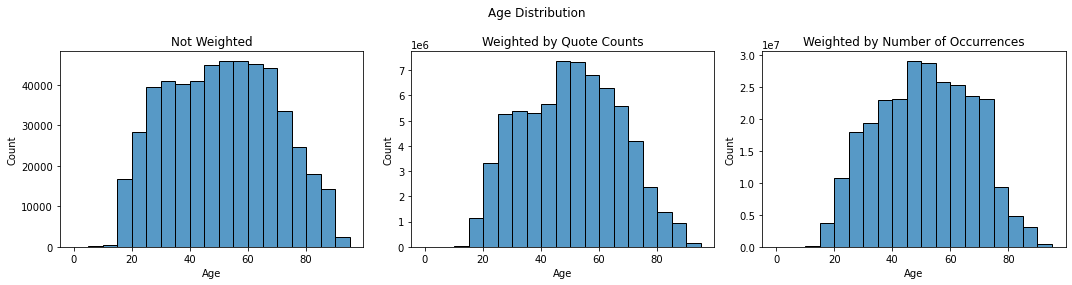

In [66]:
def plot_weighted_distribution(df, feature, n_bars = 20, figsize = (15, 4), **plot_kwargs):
    is_categorical = df.dtypes[feature] != 'float'
    feature_titled = feature.title()
    
    df = df.apply(lambda row: {feature_titled: row[feature], 
                               'Quote Counts': row['quote_count'], 
                               'Number of Occurrences': sum(row['num_occurrences'])},
                  axis = 1,
                  result_type = 'expand')
    
    df.dropna(axis = 0, how = 'any')
    df.reset_index(drop = True, inplace = True)
        
    fig, axes = plt.subplots(1, 3, figsize = figsize)
    
    if is_categorical:
        value_counts = df.groupby(feature_titled).aggregate({'Not Weighted': np.size, 'Quote Counts': np.sum, 'Number of Occurrences': np.sum})
                
    else:
    
        for ax, weight_col in zip(axes, (None, 'Quote Counts', 'Number of Occurrences')):
            sns.histplot(data = df, x = feature_titled, weights = weight_col, ax = ax, **plot_kwargs) 
            ax.set_title("Not Weighted" if weight_col is None else "Weighted by " + weight_col)
        
    fig.suptitle(feature_titled + " Distribution")
    fig.tight_layout()
    
    
plot_weighted_distribution(df, 'age', bins = range(0, 100, 5))

In [72]:
df_a = df.apply(lambda row: {'Occupation': row['occupation'], 
                               'Quote Counts': row['quote_count'], 
                               'Number of Occurrences': sum(row['num_occurrences'])},
                  axis = 1,
                  result_type = 'expand')
    

df_a.dropna(axis = 0, how = 'any')
df_a.reset_index(drop = True, inplace = True)
    

In [73]:
df_a

,Occupation,Quote Counts,Number of Occurrences
0,[Q82955],4449.0,23374.0
1,"[Q82955, Q193391]",13244.0,101453.0
2,[Q484260],1076.0,2905.0
3,[Q39631],212.0,1562.0
4,[Q500097],14.0,16.0
...,...,...,...
708571,"[Q40348, Q82955]",1.0,1.0
708572,NaN,1.0,1.0
708573,[Q2066131],1.0,1.0
708574,"[Q1650915, Q6665249]",1.0,1.0


In [70]:
value_counts = df_a.groupby('Occupation').aggregate({'Not Weighted': np.size, 'Quote Counts': np.sum, 'Number of Occurrences': np.sum})

KeyError: "Column(s) ['Not Weighted'] do not exist"

In [14]:
def find_birth_date_match(birth_date):
    matches = re.match(r'^[+-](?P<year>\d{4})-(?P<month>\d{2})-(?P<day>\d{2})T\d{2}:\d{2}:\d{2}Z$', birth_date)
    date = None
    
    if matches is not None:
        year, month, day = matches.group('year', 'month', 'day')
        date = (int(year), int(month), int(day))
        
    return date

def find_quote_date_match(quote_date):
    matches = re.match(r'(?P<year>\d{4})-(?P<month>\d{2})-(?P<day>\d{2}) \d{2}:\d{2}:\d{2}$', quote_date)
    date = None
    
    if matches is not None:
        year, month, day = matches.group('year', 'month', 'day')
        date = (int(year), int(month), int(day))
        
    return date

In [15]:
def compute_age(birth_date, quote_date):
    birth_date = find_birth_date_match(birth_date)
    quote_date = find_quote_date_match(quote_date)
    
    if birth_date is not None and quote_date is not None:
        year_birth, month_birth, day_birth = birth_date
        year_quote, month_quote, day_quote = quote_date
        
        age = year_quote - year_birth
        
        if age < 0:
            print(year_quote,year_birth, age)
        
        if month_quote < month_birth:
            age -= 1
            
        elif month_quote == month_birth and day_quote < day_birth:
            age -= 1
        
        return age
    
    else:
        print('Problems ', birth_date, quote_date )

- Check dates of birth:

**PROBLEMS:** 

1) miss quote date to compute age of person when cited \
2) how we want to manage dead people (people cited 100 years after their death) \
3) group by speaker -> if multiple quotes at different time, which age is selected ?

In [16]:
print("Percentage of missing birth_date: ", 100 * df.date_of_birth.isna().sum()/len(df.date_of_birth), "%")

Percentage of missing birth_date:  22.514874904032876 %


In [17]:
print("Percentage of missing quote date: ", 100 * df.date.isna().sum()/len(df.date), "%")

Percentage of missing quote date:  0.0 %


In [18]:
def get_speaker_age(birth_date, quote_date, min_age = 5, max_age = 90):
    """Return param: age: None if speaker too old or an error in dates format encountered.
    The value computed for the speaker age otherwise."""
    
    if birth_date is None or quote_date is None:
        return
        
    # CLEVER WAY TO FILTER MOST PROBABLE DATE FROM AMBIGUOUS ONES
    #birth_date = birth_date[0]

    # Regular expression matching to year, month and day in dates string in the two used formats. 
    date_matcher = re.compile(r"^[+]?(?P<year>-?\d{4})-(?P<month>\d{2})-(?P<day>\d{2})[T ]\d{2}:\d{2}:\d{2}Z?$")
    
    birth_date_match = date_matcher.match(birth_date)
    if birth_date_match is None:
        print("Bad formatted date:", birth_date)
        return
    
    quote_date_match = date_matcher.match(quote_date)
    if quote_date_match is None:
        print("Bad formatted date:", quote_date)
        return
        
    birth_year, birth_month, birth_day = (int(number) for number in birth_date_match.group('year', 'month', 'day'))
    quote_year, quote_month, quote_day = (int(number) for number in quote_date_match.group('year', 'month', 'day'))
    
    age = quote_year - birth_year
    if quote_month < birth_month or (quote_month == birth_month and quote_day < birth_day):
        age -= 1
    
    return age if min_age <= age <= max_age else None

In [19]:
ages = []

for qid, row in df.iterrows():
    birth_dates = row['date_of_birth']
    quote_dates = row['date']
    age = None
        
    if birth_dates is not None:
        # take first date
        birth_date = list(set(birth_dates))[0]
        quote_date = list(set(quote_dates))[0]
        age = get_speaker_age(birth_date, quote_date)
        
    ages.append(age)
        
df['age'] = ages
del ages

In [20]:
print("Percentage of missing age: ", 100 * df.age.isna().sum()/len(df.age), "%")

Percentage of missing age:  25.8234825904349 %


In [21]:
df['age'].describe()

count    525597.000000
mean         50.597646
std          18.624685
min           5.000000
25%          35.000000
50%          51.000000
75%          65.000000
max          90.000000
Name: age, dtype: float64

<AxesSubplot:xlabel='age', ylabel='Count'>

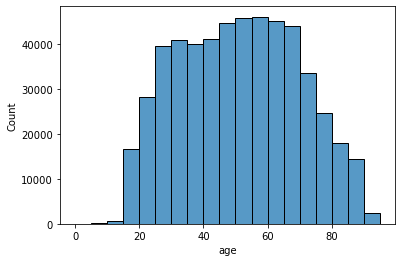

In [22]:
sns.histplot(df['age'], bins=np.arange(0,100,5))

In [ ]:
df.loc[~df['age'].isna(), ['age', 'quote_count', 'num_occurrences']].groupby('age').agg({'quote_count': np.sum, 'num_occurrences': sum})

In [ ]:
temp = df.loc[~df['age'].isna(), ['age', 'quote_count']].groupby('age').agg({'quote_count': np.sum})
sns.histplot(x='age', bins=range(0, 100, 5), weights='quote_count', data=temp);

In [83]:
temp['tot_occurrences'] = temp['num_occurrences'].apply(lambda occ: sum(occ))
sns.histplot(x='age', bins=range(0, 100, 5), weights=sum_occurences, data=temp);

KeyError: 'num_occurrences'

- Check occupation

In [33]:
print("Percentage of missing occupation: ", 100 * df.occupation.isna().sum()/len(df.occupation), "%")

Percentage of missing occupation:  7.350799349681615 %


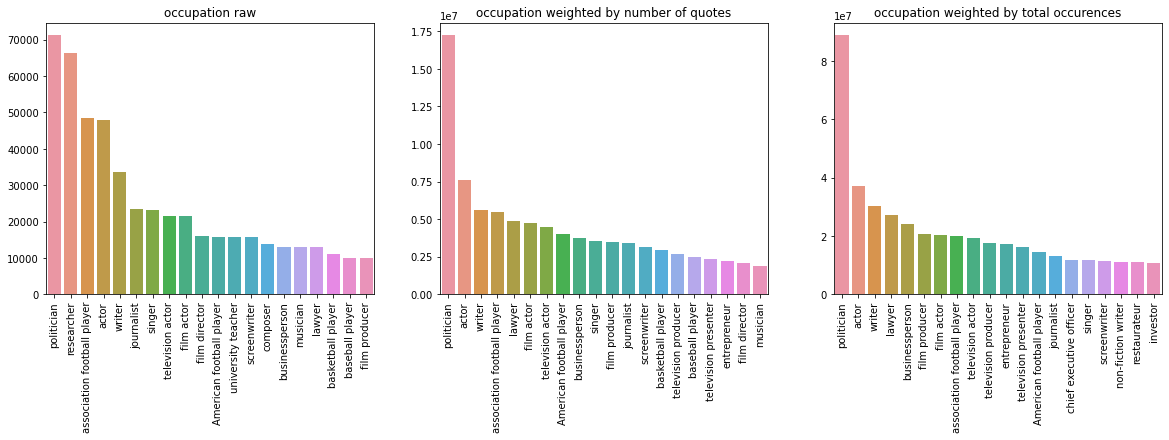

In [155]:
count_feature('occupation', number=20)

- Check gender

In [163]:
print("Percentage of missing gender: ", 100 * df.gender.isna().sum()/len(df.gender), "%")

Percentage of missing gender:  5.16712392178115 %


Text(0.5, 1.0, 'gender weighted by total occurences')

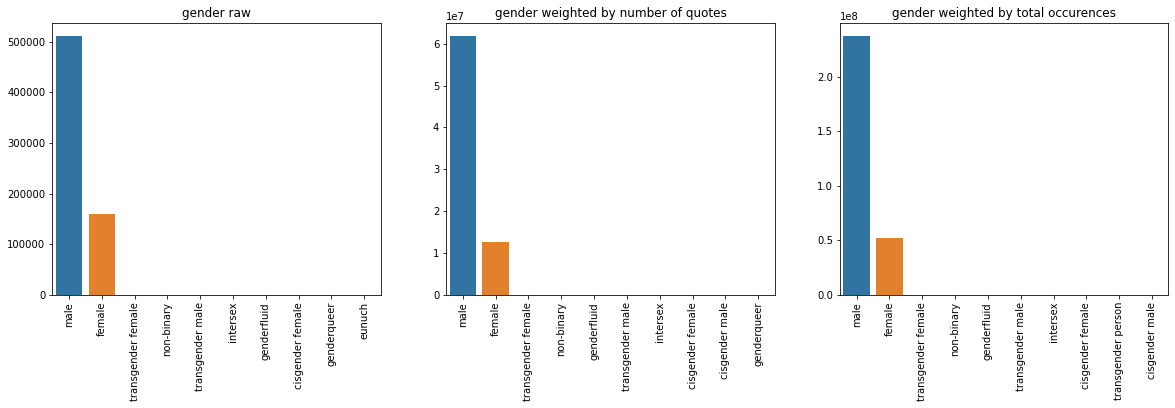

In [159]:
gender_count = Counter()
gender_count_quote_count = Counter()
gender_count_occurences = Counter()

for qid, row in df.iterrows():
    features = row['gender']
    quote_count = row['quote_count']
    occurences  = row['num_occurrences']

    if features is not None:
        for data_feature in features:
            if genders is not None and len(genders) > 0:
                # if only one gender -> OK
                if len(np.unique(genders)) == 1 and gender[0] in qid_labels.keys():
                    gender_count.update([qid_labels[data_feature]])
                    gender_count_quote_count.update([qid_labels[data_feature[0]]]*quote_count)
                    gender_count_occurences.update([qid_labels[data_feature[0]]]*sum(occurences))

                else:
                # if multiple genders -> keep all
                    for gender in genders:
                        if gender in qid_labels.keys():
                            gender_count.update([qid_labels[data_feature]])
                            gender_count_quote_count.update([qid_labels[data_feature]]*quote_count)
                            gender_count_occurences.update([qid_labels[data_feature]]*sum(occurences))
    

fig, axs = plt.subplots(1, 3)
fig.set_size_inches(20, 5)

plot_feature_occurences(gender_count, ax=axs[0], number=10)
axs[0].set_title("gender raw")

plot_feature_occurences(gender_count_quote_count, ax=axs[1], number=10)
axs[1].set_title("gender weighted by number of quotes")

plot_feature_occurences(gender_count_occurences, ax=axs[2], number=10)
axs[2].set_title("gender weighted by total occurences")

- check nationality

In [164]:
print("Percentage of missing nationality: ", 100 * df.nationality.isna().sum()/len(df.nationality), "%")

Percentage of missing nationality:  26.68210608318656 %


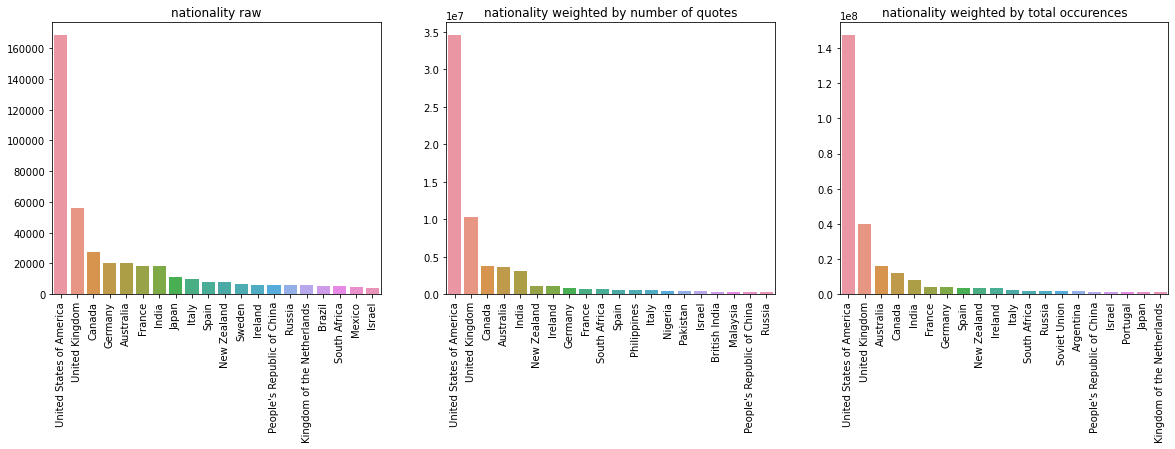

In [156]:
count_feature('nationality', number=20)

- check ethnicity

In [161]:
print("Percentage of missing ethnic_group: ", 100 * df.ethnic_group.isna().sum()/len(df.ethnic_group), "%")

Percentage of missing ethnic_group:  97.38574267262791 %


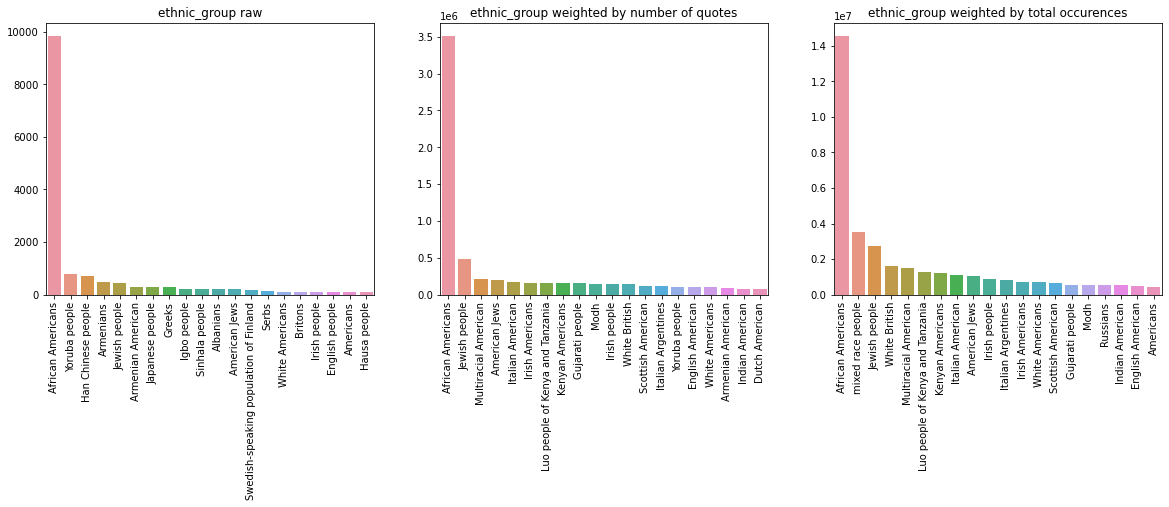

In [157]:
count_feature('ethnic_group', number=20)

- check religion

In [162]:
print("Percentage of missing religion: ", 100 * df.religion.isna().sum()/len(df.religion), "%")

Percentage of missing religion:  96.88953619654066 %


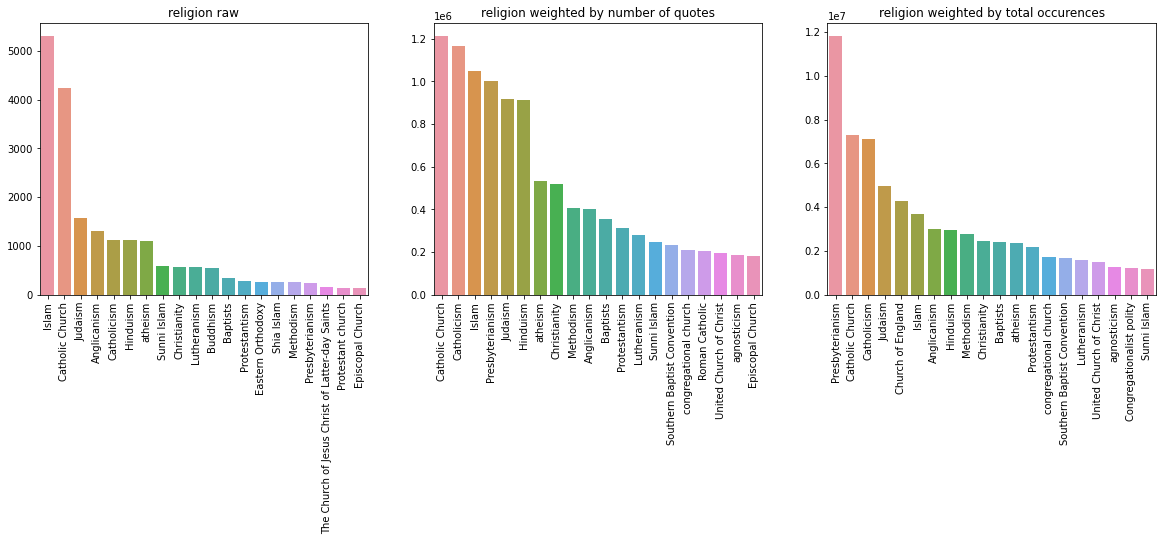

In [158]:
count_feature('religion', number=20)